In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn import preprocessing
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import mlflow

import logging
import pickle
import bisect

import sys
from datetime import datetime

# setting path
sys.path.append('../scripts')
from preprocessing_functions import weekends, time_of_month, label_holidays


Bad key "text.kerning_factor" on line 4 in
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Load Dataset

In [3]:
logging.info('Load Training Set')

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
df_train = pd.read_csv('../data/train_clean.csv', na_values=['?', None, 'undefined'])
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,1,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,1,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,1,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,1,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,1,31,7,2015


In [5]:
logging.info('Load Test Set')

In [6]:
df_test = pd.read_csv('../data/test_clean.csv', na_values=['?', None, 'undefined'])
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,0,17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,0,17,9,2015
2,3,7,4,2015-09-17,1.0,1,0,0,0,17,9,2015
3,4,8,4,2015-09-17,1.0,1,0,0,0,17,9,2015
4,5,9,4,2015-09-17,1.0,1,0,0,0,17,9,2015


In [7]:
logging.info('Load Store Info')

In [8]:
df_store = pd.read_csv('../data/store.csv', na_values=['?', None, 'undefined'])
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Add some more features to dataset

In [24]:
df_train['Weekend'] = df_train['DayOfWeek'].apply(weekends)
df_test['Weekend'] = df_test['DayOfWeek'].apply(weekends)

df_train['TimeOfMonth'] = df_train['Day'].apply(time_of_month)
df_test['TimeOfMonth'] = df_test['Day'].apply(time_of_month)

df_train['Holiday'] = df_train['StateHoliday'].apply(label_holidays)
df_test['Holiday'] = df_test['StateHoliday'].apply(label_holidays)

df_train['Date'] = pd.DatetimeIndex(df_train['Date'])


In [25]:
df_weekends = df_train[['Store', 'DayOfWeek','Open', 'Sales','Customers']]
df_weekends = df_weekends[df_weekends['Open'] == 1]
weekend_stores = df_weekends[['Store', 'DayOfWeek']].groupby('Store').nunique()
weekend_stores = weekend_stores[weekend_stores['DayOfWeek'] == 7].reset_index()
len(weekend_stores)

33

In [26]:
df_weekends = df_weekends[df_weekends['Store'].isin(set(weekend_stores['Store']))]
weekendstores = set(df_weekends['Store'])

def isallweekstore(x):
    if x in weekendstores:
        return 1
    return 0

df_train['7DayStore'] = df_train['Store'].apply(isallweekstore)

In [27]:

df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].max())
df_store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [28]:
df_train = df_train.merge(df_store, on='Store', how='left')
df_test = df_test.merge(df_store, on='Store', how='left')

In [40]:

holidays = np.array(df_train[df_train["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)

def days_from_holiday(dates, holidays):
    days_till, days_after = [], []
    for day in dates:
        ind = bisect.bisect(holidays, day)
        if len(holidays) == ind:
            days_till.append(0)
            days_after.append((day - holidays[ind - 1]).days)
        else:
            days_till.append((day - holidays[ind - 1]).days)
            days_after.append((holidays[ind] - day).days)
    return days_till, days_after

df_train["TillHday"], df_train["AfterHday"] = days_from_holiday(df_train["Date"], holidays)


In [42]:
df_train.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth,7DayStore,StoreType_x,Assortment_x,CompetitionDistance_x,CompetitionOpenSinceMonth_x,CompetitionOpenSinceYear_x,Promo2_x,Promo2SinceWeek_x,Promo2SinceYear_x,PromoInterval_x,StoreType_y,Assortment_y,CompetitionDistance_y,CompetitionOpenSinceMonth_y,CompetitionOpenSinceYear_y,Promo2_y,Promo2SinceWeek_y,Promo2SinceYear_y,PromoInterval_y,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,TillHday,AfterHday
994319,525,1,2013-01-21,12237,961,1,1,0,0,1,21,1,2013,0,2,0,d,c,1870.0,9.0,2013.0,0,NaN,NaN,NaN,d,c,1870.0,9.0,2013.0,0,NaN,NaN,NaN,d,c,1870.0,9.0,2013.0,0,NaN,NaN,NaN,15,67
243168,299,3,2014-12-24,4914,443,1,0,0,1,1,24,12,2014,0,2,1,d,c,38630.0,9.0,2012.0,0,NaN,NaN,NaN,d,c,38630.0,9.0,2012.0,0,NaN,NaN,NaN,d,c,38630.0,9.0,2012.0,0,NaN,NaN,NaN,35,1
43444,1075,2,2015-06-23,9417,873,1,0,0,0,1,23,6,2015,0,2,0,a,c,1410.0,10.0,2013.0,0,NaN,NaN,NaN,a,c,1410.0,10.0,2013.0,0,NaN,NaN,NaN,a,c,1410.0,10.0,2013.0,0,NaN,NaN,NaN,0,19
355717,715,2,2014-08-26,3513,417,1,0,0,1,0,26,8,2014,0,2,0,a,a,14810.0,6.0,2014.0,0,NaN,NaN,NaN,a,a,14810.0,6.0,2014.0,0,NaN,NaN,NaN,a,a,14810.0,6.0,2014.0,0,NaN,NaN,NaN,68,38
466220,936,6,2014-05-10,6013,753,1,0,0,0,1,10,5,2014,1,0,0,a,a,580.0,2.0,2008.0,0,NaN,NaN,NaN,a,a,580.0,2.0,2008.0,0,NaN,NaN,NaN,a,a,580.0,2.0,2008.0,0,NaN,NaN,NaN,9,19
290858,304,1,2014-11-03,9218,1204,1,1,0,1,1,3,11,2014,0,0,0,a,a,1950.0,7.0,2015.0,0,NaN,NaN,NaN,a,a,1950.0,7.0,2015.0,0,NaN,NaN,NaN,a,a,1950.0,7.0,2015.0,0,NaN,NaN,NaN,2,16
246900,290,6,2014-12-20,6652,614,1,0,0,0,1,20,12,2014,1,1,0,a,a,4150.0,5.0,2001.0,0,NaN,NaN,NaN,a,a,4150.0,5.0,2001.0,0,NaN,NaN,NaN,a,a,4150.0,5.0,2001.0,0,NaN,NaN,NaN,31,5
638719,610,5,2013-12-06,4233,501,1,1,0,0,1,6,12,2013,0,0,0,a,a,660.0,1.0,2007.0,0,NaN,NaN,NaN,a,a,660.0,1.0,2007.0,0,NaN,NaN,NaN,a,a,660.0,1.0,2007.0,0,NaN,NaN,NaN,16,19
1012883,134,5,2013-01-04,4695,488,1,0,0,1,1,4,1,2013,0,0,0,a,a,1200.0,9.0,2008.0,0,NaN,NaN,NaN,a,a,1200.0,9.0,2008.0,0,NaN,NaN,NaN,a,a,1200.0,9.0,2008.0,0,NaN,NaN,NaN,3,2
528318,594,6,2014-03-15,2202,225,1,0,0,0,0,15,3,2014,1,1,0,a,a,1790.0,10.0,2011.0,0,NaN,NaN,NaN,a,a,1790.0,10.0,2011.0,0,NaN,NaN,NaN,a,a,1790.0,10.0,2011.0,0,NaN,NaN,NaN,68,34


In [43]:
le = preprocessing.LabelEncoder()
df_train['StoreType'] = le.fit_transform(df_train['StoreType'])
df_train['Assortment'] = le.fit_transform(df_train['Assortment'])

df_test['StoreType'] = le.fit_transform(df_test['StoreType'])
df_test['Assortment'] = le.fit_transform(df_test['Assortment'])

In [44]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth,StoreType_x,Assortment_x,CompetitionDistance_x,CompetitionOpenSinceMonth_x,CompetitionOpenSinceYear_x,Promo2_x,Promo2SinceWeek_x,Promo2SinceYear_x,PromoInterval_x,StoreType_y,Assortment_y,CompetitionDistance_y,CompetitionOpenSinceMonth_y,CompetitionOpenSinceYear_y,Promo2_y,Promo2SinceWeek_y,Promo2SinceYear_y,PromoInterval_y,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,0,2,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,0,0,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,1,17,9,2015,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,0,2,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [16]:
# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]
    

# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]

In [17]:
# holidays = pd.Series(list(set(df_train[df_train['StateHoliday'] != '0']['Date'])))

In [45]:
x = df_train[['Store','DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
              'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']]
y_scaler = StandardScaler()
y = y_scaler.fit_transform(df_train[['Sales']].values)
train_features = x.columns
x = x.values

### Linear Regression Pipeline with 5 fold cross validation

In [46]:

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='linear_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        reg_pipe.fit(X_train, y_train)
        score = reg_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, reg_pipe.predict(X_test))
        print("r2_score:", score)
        print("mean squared error:", mse)
        #log model params
        mlflow.log_param("lin_reg_score", score)
        mlflow.log_param("lin_reg_mse", mse)
        # log model
        mlflow.sklearn.log_model(reg_pipe, "lin_regression_models")
        mlflow.end_run()

r2_score: 0.5785106007468976
mean squared error: 0.42459720020503827
r2_score: 0.5451727627831473
mean squared error: 0.4688936617209662
r2_score: 0.5786219091466519
mean squared error: 0.4148868928296225
r2_score: 0.5288398957397078
mean squared error: 0.4828267153474507
r2_score: 0.5467591677889365
mean squared error: 0.42694664158206297


### Random Forest Regressor Pipeline with 5 fold cross validation

In [47]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='random_forest_reg_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        forest_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 10, max_depth = 20))])
        forest_pipe.fit(X_train, y_train)
        score = forest_pipe.score(X_test, y_test)
        print("score:", score)
        #log model params
        mlflow.log_param("rand_forest_reg_score", score)

        # log model
        mlflow.sklearn.log_model(forest_pipe, "random_forest_regression_models")
        mlflow.end_run()

score: 0.881936901886228
score: 0.8937866916653645
score: 0.9032692321332086
score: 0.8832760998327295
score: 0.9003334280476052


### Save Model

In [72]:
filename = '../models/forest-'+datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+f'-{now.microsecond}.sav'
pickle.dump(forest_pipe, open(filename, 'wb'))

In [71]:
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=10))])

### Feature importance

#### Linear Regression Model

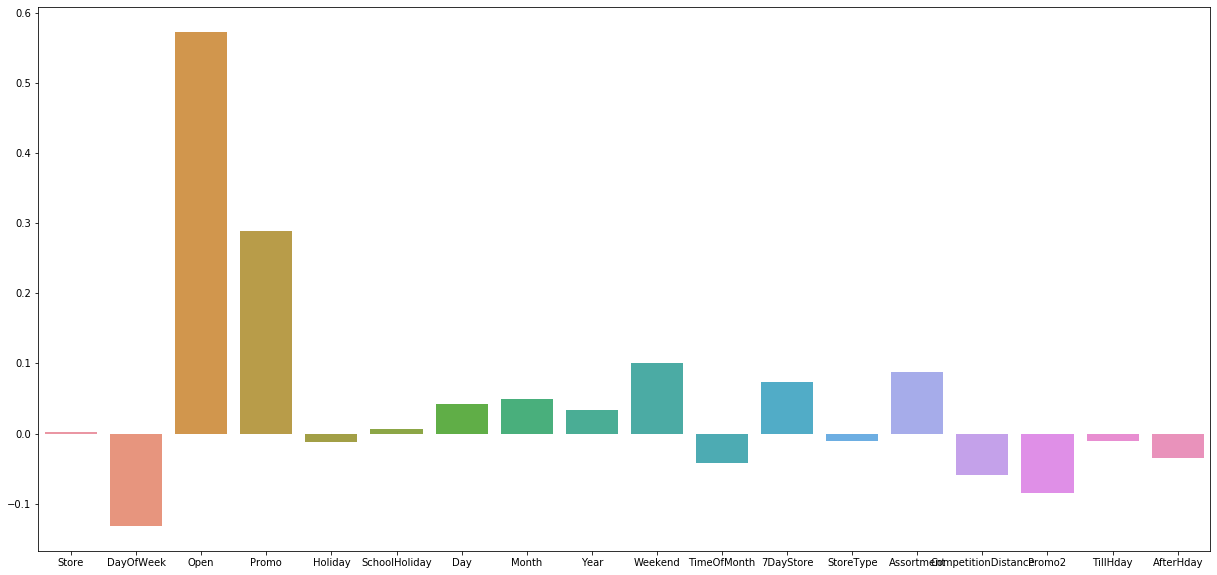

In [48]:
plt.figure(figsize=(21,10))
sns.barplot(x = train_features, y = reg_pipe[1].coef_[0])

<h5> As Day of week, time of month, distance from competition, and Promo2 increase, the sales value decreases
The most important features are whether the store was open and whether the store ran a promo. </h5>

#### Random Forest Regression Model Feature Importance

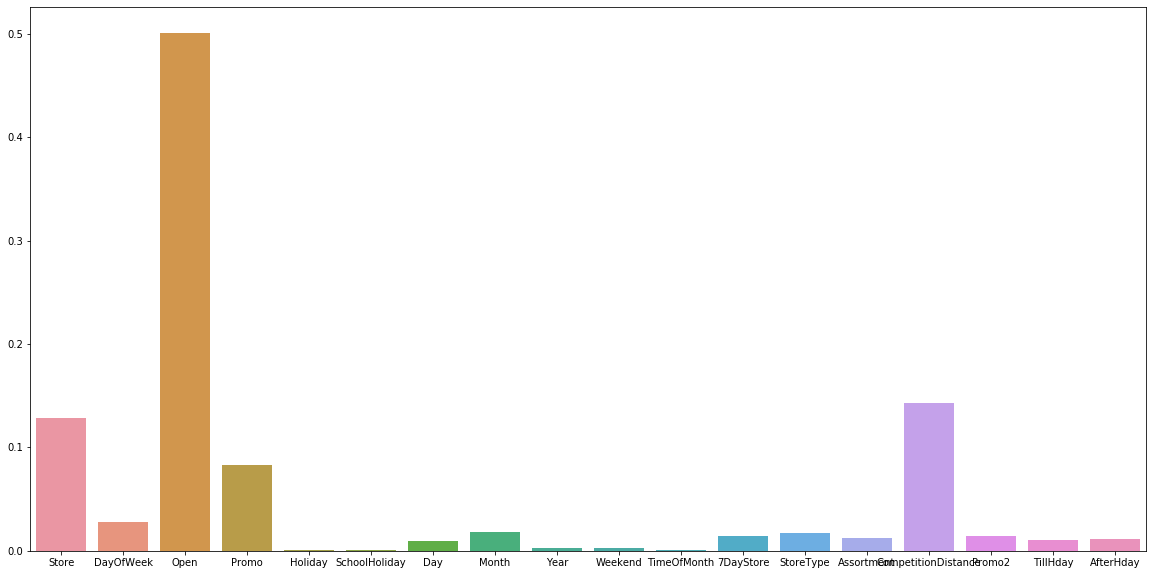

In [49]:
plt.figure(figsize=(20,10))
sns.barplot(x = train_features, y = forest_pipe[1].feature_importances_)

<h5> Here, the most important features are whether it's open, the store id, the competition distance, and whether a promo was done on that day or not <h5>